In [1]:
!pip install scipy progressbar2
import os
import wget
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import progressbar
%matplotlib inline

You should consider upgrading via the '/home/ekrem/.pyenv/versions/3.6.12/envs/htwg-ml/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
%reload_ext version_information
%version_information numpy, sklearn

Software versions
Python 3.6.12 64bit [GCC 9.3.0]
IPython 7.16.1
OS Linux 5.4.0 54 generic x86_64 with debian bullseye sid
numpy 1.18.5
sklearn 0.23.2
Tue Dec 01 12:38:36 2020 CET

In [3]:
fishing_file = os.path.join(os.getcwd(), 'fishing.npz')

if not os.path.isfile(fishing_file):
    print("Downloading file...\n")

    wget.download('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', fishing_file)

fishing_data = np.load(fishing_file)

In [4]:
X_train = fishing_data['Xt']    # "livebait", "camper", "persons", "child"
y_train = fishing_data['yt']

X_test = fishing_data['Xte']
y_test = fishing_data['yte']

pd.DataFrame(X_train, columns=["livebait", "camper", "persons", "child"])

,livebait,camper,persons,child
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0
2,1.0,1.0,3.0,0.0
3,1.0,1.0,3.0,2.0
4,1.0,1.0,4.0,1.0
...,...,...,...,...
195,1.0,1.0,1.0,0.0
196,1.0,1.0,1.0,0.0
197,1.0,1.0,3.0,0.0
198,1.0,0.0,1.0,0.0


In [5]:
X_designmatrix =  np.c_[np.ones((len(X_train), 1)), X_train]
X_test_designmatrix =  np.c_[np.ones((len(X_test), 1)), X_test]

pd.DataFrame(X_designmatrix, columns=["intercept", "livebait", "camper", "persons", "child"])

,intercept,livebait,camper,persons,child
0,1.0,1.0,0.0,4.0,0.0
1,1.0,1.0,1.0,2.0,0.0
2,1.0,1.0,1.0,3.0,0.0
3,1.0,1.0,1.0,3.0,2.0
4,1.0,1.0,1.0,4.0,1.0
...,...,...,...,...,...
195,1.0,1.0,1.0,1.0,0.0
196,1.0,1.0,1.0,1.0,0.0
197,1.0,1.0,1.0,3.0,0.0
198,1.0,1.0,0.0,1.0,0.0


## a.) Lineare Regression wie in Vorlesung

In [6]:
weights = np.linalg.inv(X_designmatrix.T @ X_designmatrix) @ X_designmatrix.T @ y_train

print("Weights: {}".format(weights))

Weights: [-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


## b.) Lineare Regression mit sklearn

In [7]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print("Bias/Intercept: {}, Weights: {}".format(reg.intercept_, reg.coef_))

Bias/Intercept: -8.492231369018555, Weights: [ 2.4822128  2.9543095  4.6495404 -5.4716005]


## c.) RMSE und NLL berechnen

In [8]:
y_pred = np.sum(reg.coef_.T * X_test, axis=1) + reg.intercept_

rmse = mean_squared_error(y_test, y_pred, squared=False)

residuals = y_test - y_pred
var = np.var(residuals)
mean = np.mean(residuals)
std = np.std(residuals)

cpd = [stats.norm(mean, std).pdf(residual) for residual in residuals]
nll = -np.sum(np.log(cpd)) / len(y_test)

print("RMSE: {} - var: {} - NLL: {}".format(rmse, var, nll))

RMSE: 8.588127136230469 - var: 73.48030853271484 - NLL: 3.567447225436254


## d.) Plotten

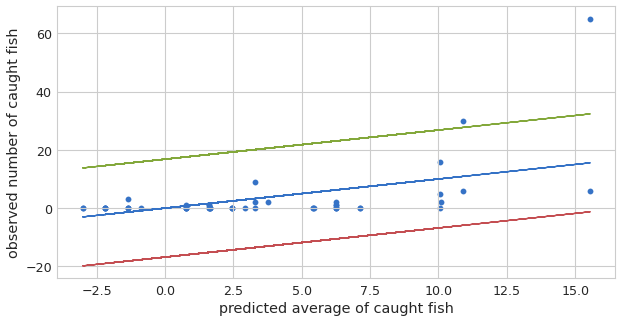

In [9]:
p1 = y_pred + 1.96 * std
p2 = y_pred - 1.96 * std

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(y_pred, y_test)

plt.plot(y_pred, y_pred)
plt.plot(y_pred, p1)
plt.plot(y_pred, p2)

plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

plt.show()

## e.) RMSE & NLL mit Poisson-Verteilung

In [10]:
def nll_poisson(k, x, beta):
    mu = np.exp(x @ beta)

    values = []
    for i in range(len(k)):
        log_k_fact = np.log(1.0 * np.math.factorial(k[i]))
        values.append(- mu[i] + k[i] * np.log(mu[i]) - log_k_fact)

    return - np.mean(values)

nll_poisson(y_train, X_designmatrix, np.ones(5))

1507.9856602262082

In [11]:
def nll_gradient(k, x, beta):
    mu = np.exp(x @ beta)

    values = []
    for i in range(len(k)):
        values.append(- mu[i] * x[i] + k[i] * x[i])

    return np.mean(values, axis=0)

nll_gradient(y_train, X_designmatrix, np.ones(5))

array([-1518.61304305, -1403.99474131, -1171.02247951, -5701.91224653,
       -3258.70389229])

In [12]:
epochs = 5000
learning_rate = 0.001

weights = np.ones(5)

for i in progressbar.progressbar(range(epochs)):
    weights = weights + learning_rate * nll_gradient(y_train, X_designmatrix, weights)

print("Weights: {} - NLL: {}".format(weights, nll_poisson(y_train, X_designmatrix, weights)))

100% (5000 of 5000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


Weights: [-1.08852056  0.2597268   0.54509109  0.85448041 -1.65101241] - NLL: 3.4917536727865155


In [13]:
y_pred = np.exp(X_test_designmatrix @ weights)

rmse = mean_squared_error(y_test, y_pred, squared=False)
nll = nll_poisson(y_test, X_test_designmatrix, weights)

print("RMSE: {} - NLL: {}".format(rmse, nll))

RMSE: 7.606839288683508 - NLL: 3.0692866711267768


## f.) Plotten

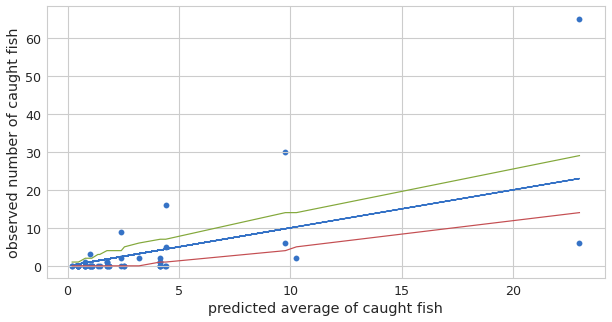

In [14]:
p1 = stats.poisson.ppf(q=0.9, mu=np.sort(y_pred))
p2 = stats.poisson.ppf(q=0.025, mu=np.sort(y_pred))

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(y_pred, y_test)

plt.plot(y_pred, y_pred)
plt.plot(np.sort(y_pred), p1)
plt.plot(np.sort(y_pred), p2)

plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')

plt.show()